In [1]:
# @title
!pip install apafib --upgrade  --quiet

  Preparing metadata (setup.py) ... done


### imports necesarios

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config

from yellowbrick.regressor import AlphaSelection

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.precision', 3)

# **Problema individual 6: Cuidado con donde aparcas**


El conducir por grandes ciudades tiene emparejado el caos y el no saber donde dejar el coche.
Los ayuntamientos no dejan pasar ni una y están prestos a multar la menor infracción. El ayuntamiento de Barcelona recolecta diversos datos sobre la ciudad en su portal de datos abiertos6
y quiere estudiar cuáles son las circunstancias que influyen en el número de infracciones que se
realizan en la ciudad. Vamos a trabajar con un extracto de esos datos para los años 2022-2023,
eligiendo un subconjunto de variables relacionadas con el tráfico y sus circunstancias (y una
variable extra adicional, por si acaso). Tenemos la contaminación medida en la estación meteorológica de l’Eixample (NO2), la contaminación acústica a diferentes horas del día, el tránsito en
diferentes franjas horarias, la temperatura del día y el número de personas de otros municipios
cercanos que vinieron a Barcelona. El objetivo es estimar el número de sanciones que se ponen
en el día.

# Apartado A

Divide el conjunto de datos en entrenamiento y test (60 %/40 %). Haz una exploración mínima del conjunto de datos de entrenamiento observando las relaciones entre las variables,especialmente con la variable objetivo. Describe las cosas que hayas visto que te parez-
can interesantes. Transforma las variables adecuadamente para poder ajustar un modelo
de regresión tanto para el conjunto de entrenamiento como para el de test.

## Exploración de los datos

Vemos que formato tienen los datos

In [3]:
from apafib import load_BCN_sanciones
raw_df = load_BCN_sanciones()
raw_df.head()

,Sanciones-Numero,IBEX-IBEX,Temperatura-Barcelona - Zona Universitària,TransitoHoras-Nit (0-5),TransitoHoras-Matí (6-13),TransitoHoras-Tarda (14-19),TransitoHoras-Vespre (20-24),VisitantesMunicipales-Badalona,VisitantesMunicipales-L'Hospitalet de Llobregat,VisitantesMunicipales-Sabadell,VisitantesMunicipales-Santa Coloma de Gramenet,VisitantesMunicipales-Terrassa,ContaminacionAcustica-19h,ContaminacionAcustica-4h,ContaminantesEixample-Mitjana NO2
Dia,,,,,,,,,,,,,,,
2022-05-13,3026.0,8338.1,19.13,1.201,2.026,2.214,1.698,74601.0,90449.0,20290.0,36932.0,24687.0,67.80,54.66,60.58
2022-05-14,1671.0,8343.3,21.52,1.213,1.759,1.803,1.695,61050.0,81027.0,19391.0,33755.0,23209.0,66.51,57.18,53.79
2022-05-15,1659.0,8348.5,22.32,1.264,1.545,1.814,1.651,54080.0,74599.0,16397.0,32933.0,21983.0,66.92,56.34,54.00
2022-05-16,2712.0,8353.7,22.25,1.262,2.031,1.962,1.607,73664.0,89460.0,18791.0,37181.0,24275.0,67.33,53.73,59.54
2022-05-17,2699.0,8475.7,21.95,1.237,2.148,2.124,1.563,72504.0,89622.0,20053.0,37182.0,24613.0,67.30,52.93,58.88


Vemos el tipo de varibale de las features del data set.

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 590 entries, 2022-05-13 to 2023-12-23
Data columns (total 15 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Sanciones-Numero                                 590 non-null    float64
 1   IBEX-IBEX                                        590 non-null    float64
 2   Temperatura-Barcelona - Zona Universitària       590 non-null    float64
 3   TransitoHoras-Nit (0-5)                          590 non-null    float64
 4   TransitoHoras-Matí (6-13)                        590 non-null    float64
 5   TransitoHoras-Tarda (14-19)                      590 non-null    float64
 6   TransitoHoras-Vespre (20-24)                     590 non-null    float64
 7   VisitantesMunicipales-Badalona                   590 non-null    float64
 8   VisitantesMunicipales-L'Hospitalet de Llobregat  590 non-null    float64
 9   VisitantesMunicipales

Vemos que conjunto de datos tiene 500 muestras y 15 variables. Nuestra variable objetivo es `Sanciones-Numero`.

## Renombramiento variables



Dado que vemos que las variables originales tienen unos nombres bastante largos, hacemos un renombramiento con nombres simplificados que facilitaran el análasis.



In [5]:
nuevos_nombres = {
    'Sanciones-Numero' : 'sanciones',
    'IBEX-IBEX' : 'ibex',
    'Temperatura-Barcelona - Zona Universitària' : 'temp_ZU',
    'TransitoHoras-Nit (0-5)' : 'transito_0-5',
    'TransitoHoras-Matí (6-13)' : 'transito_6-13',
    'TransitoHoras-Tarda (14-19)' : 'transito_14-19',
    'TransitoHoras-Vespre (20-24)' : 'transito_20-23',
    'VisitantesMunicipales-Badalona' : 'vis_badalona',
    "VisitantesMunicipales-L'Hospitalet de Llobregat" : 'vis_hospitalet',
    'VisitantesMunicipales-Sabadell' : 'vis_sabadell',
    'VisitantesMunicipales-Santa Coloma de Gramenet' : 'vis_santaco',
    'VisitantesMunicipales-Terrassa' : 'vis_terrassa',
    'ContaminacionAcustica-19h' : 'ruido_19',
    'ContaminacionAcustica-4h' : 'ruido_4',
    'ContaminantesEixample-Mitjana NO2' : 'no2'
}

raw_df.rename(columns=nuevos_nombres, inplace=True)
raw_df.head()

,sanciones,ibex,temp_ZU,transito_0-5,transito_6-13,transito_14-19,transito_20-23,vis_badalona,vis_hospitalet,vis_sabadell,vis_santaco,vis_terrassa,ruido_19,ruido_4,no2
Dia,,,,,,,,,,,,,,,
2022-05-13,3026.0,8338.1,19.13,1.201,2.026,2.214,1.698,74601.0,90449.0,20290.0,36932.0,24687.0,67.80,54.66,60.58
2022-05-14,1671.0,8343.3,21.52,1.213,1.759,1.803,1.695,61050.0,81027.0,19391.0,33755.0,23209.0,66.51,57.18,53.79
2022-05-15,1659.0,8348.5,22.32,1.264,1.545,1.814,1.651,54080.0,74599.0,16397.0,32933.0,21983.0,66.92,56.34,54.00
2022-05-16,2712.0,8353.7,22.25,1.262,2.031,1.962,1.607,73664.0,89460.0,18791.0,37181.0,24275.0,67.33,53.73,59.54
2022-05-17,2699.0,8475.7,21.95,1.237,2.148,2.124,1.563,72504.0,89622.0,20053.0,37182.0,24613.0,67.30,52.93,58.88


## Preprocesado

Miramos con la función describe una primera vista de los valores de cada variable, vemos que todas las variables son númericas, no tenemos ninguna categórica, por tanto no hace falta realizar ningun one-hot encoding.

In [6]:
raw_df.describe()

,sanciones,ibex,temp_ZU,transito_0-5,transito_6-13,transito_14-19,transito_20-23,vis_badalona,vis_hospitalet,vis_sabadell,vis_santaco,vis_terrassa,ruido_19,ruido_4,no2
count,590.000,590.000,590.000,590.000,590.000,590.000,590.000,590.000,590.000,590.000,590.000,590.000,590.000,590.000,590.000
mean,2491.659,8854.795,19.818,1.235,1.917,2.034,1.637,67418.047,94353.181,21937.653,45470.690,24042.597,65.989,54.305,36.472
std,771.420,684.702,6.137,0.104,0.233,0.219,0.119,8287.555,10682.142,3465.832,6291.506,3598.093,1.113,1.997,12.199
min,566.000,7261.100,4.790,0.143,0.697,1.501,0.383,41690.000,60441.000,11692.000,26127.000,13689.000,62.130,49.610,13.580
25%,1849.250,8238.075,14.793,1.200,1.739,1.828,1.579,61212.500,86527.750,19496.500,41199.750,21469.000,65.350,52.770,27.590
50%,2638.000,9072.850,20.575,1.232,2.039,2.111,1.635,69426.500,94913.500,22289.000,46926.000,24847.000,66.135,54.095,34.165
75%,3081.750,9355.100,25.150,1.260,2.102,2.208,1.700,73852.250,101655.000,24838.750,49569.500,26832.000,66.850,55.880,44.000
max,4414.000,10258.100,32.880,1.589,2.254,2.462,1.978,82270.000,115812.000,30013.000,56954.000,34081.000,68.720,63.800,83.000


Buscamos posibles valores faltantes en los datos y vemos que no tenemos ningun valor nulo, por tanto no hace falta utilizar ninguna estrategia para inputar datos como el KNN.

In [7]:
raw_df.isnull().sum()

,0
sanciones,0
ibex,0
temp_ZU,0
transito_0-5,0
transito_6-13,0
transito_14-19,0
transito_20-23,0
vis_badalona,0
vis_hospitalet,0
vis_sabadell,0


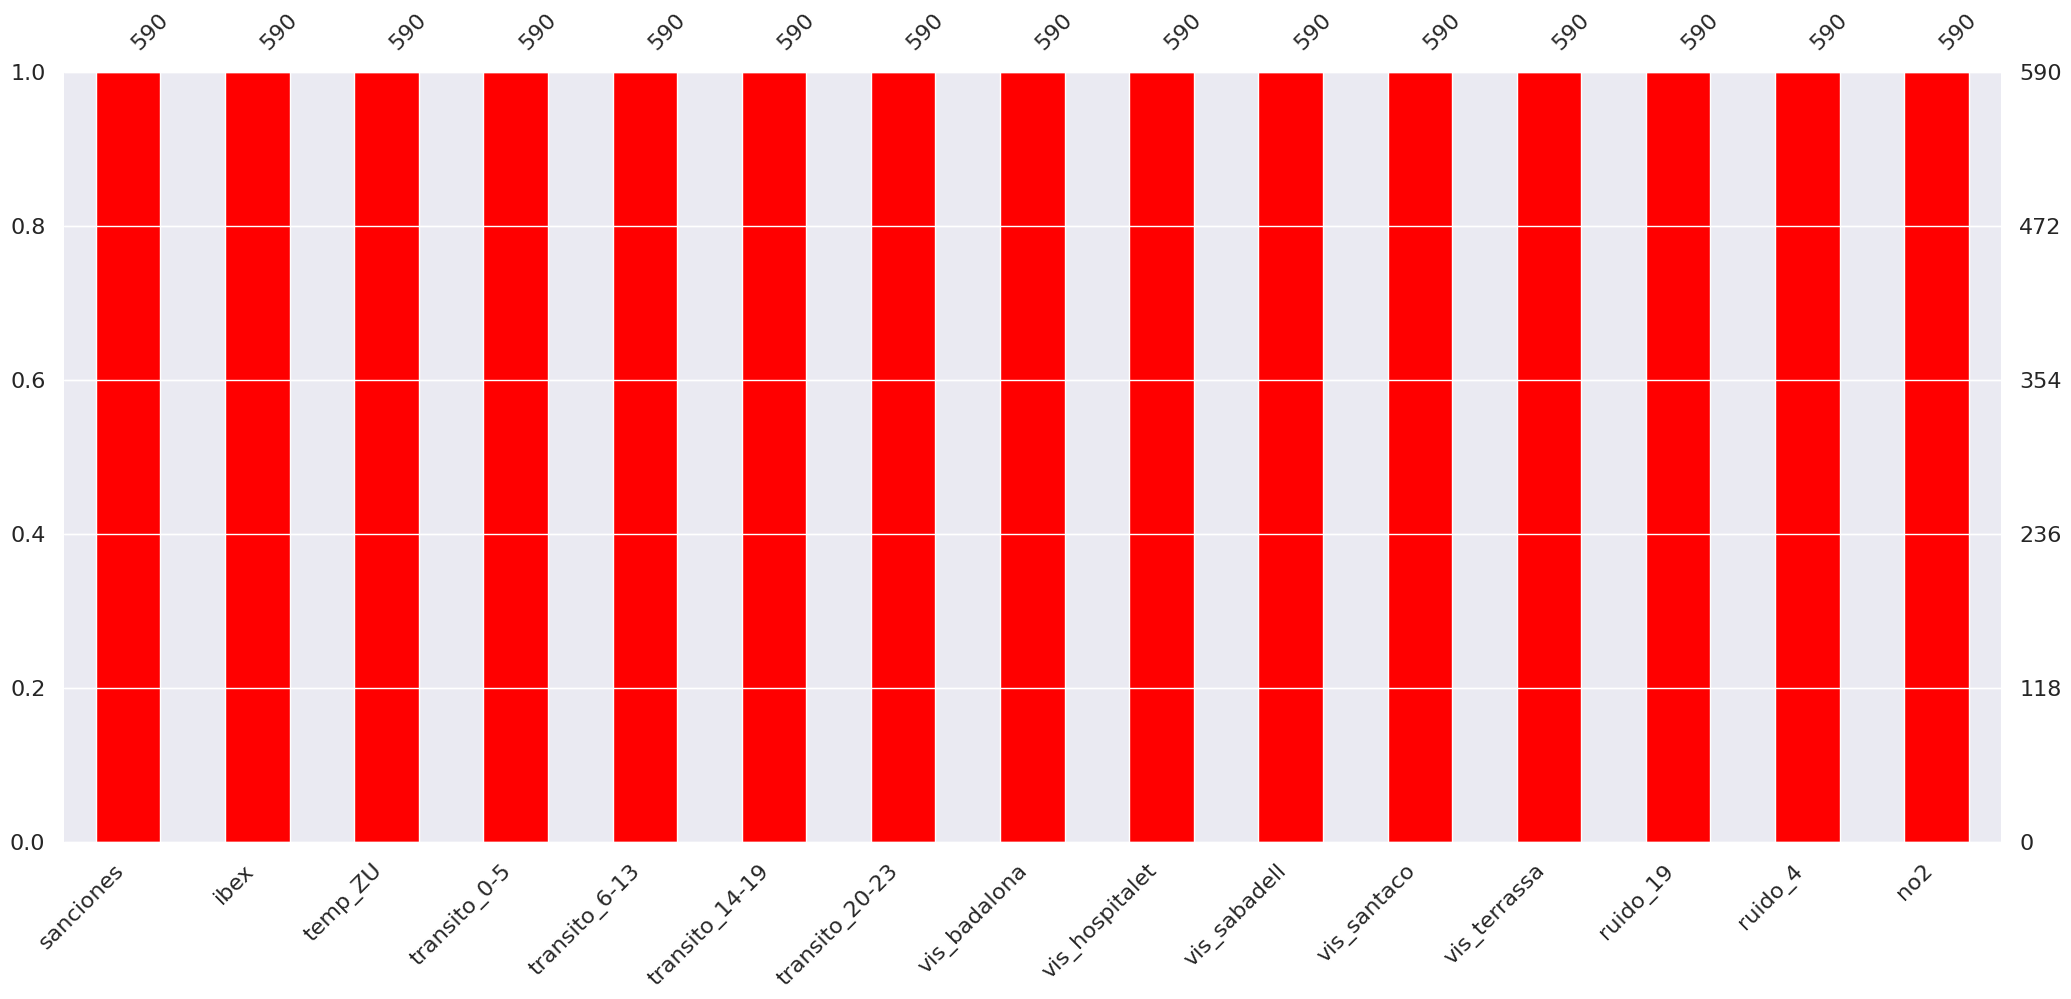

In [8]:
plt.figure(figsize=(20,5))
msno.bar(raw_df, color="red")
plt.show()

## Visualizacion de las variables

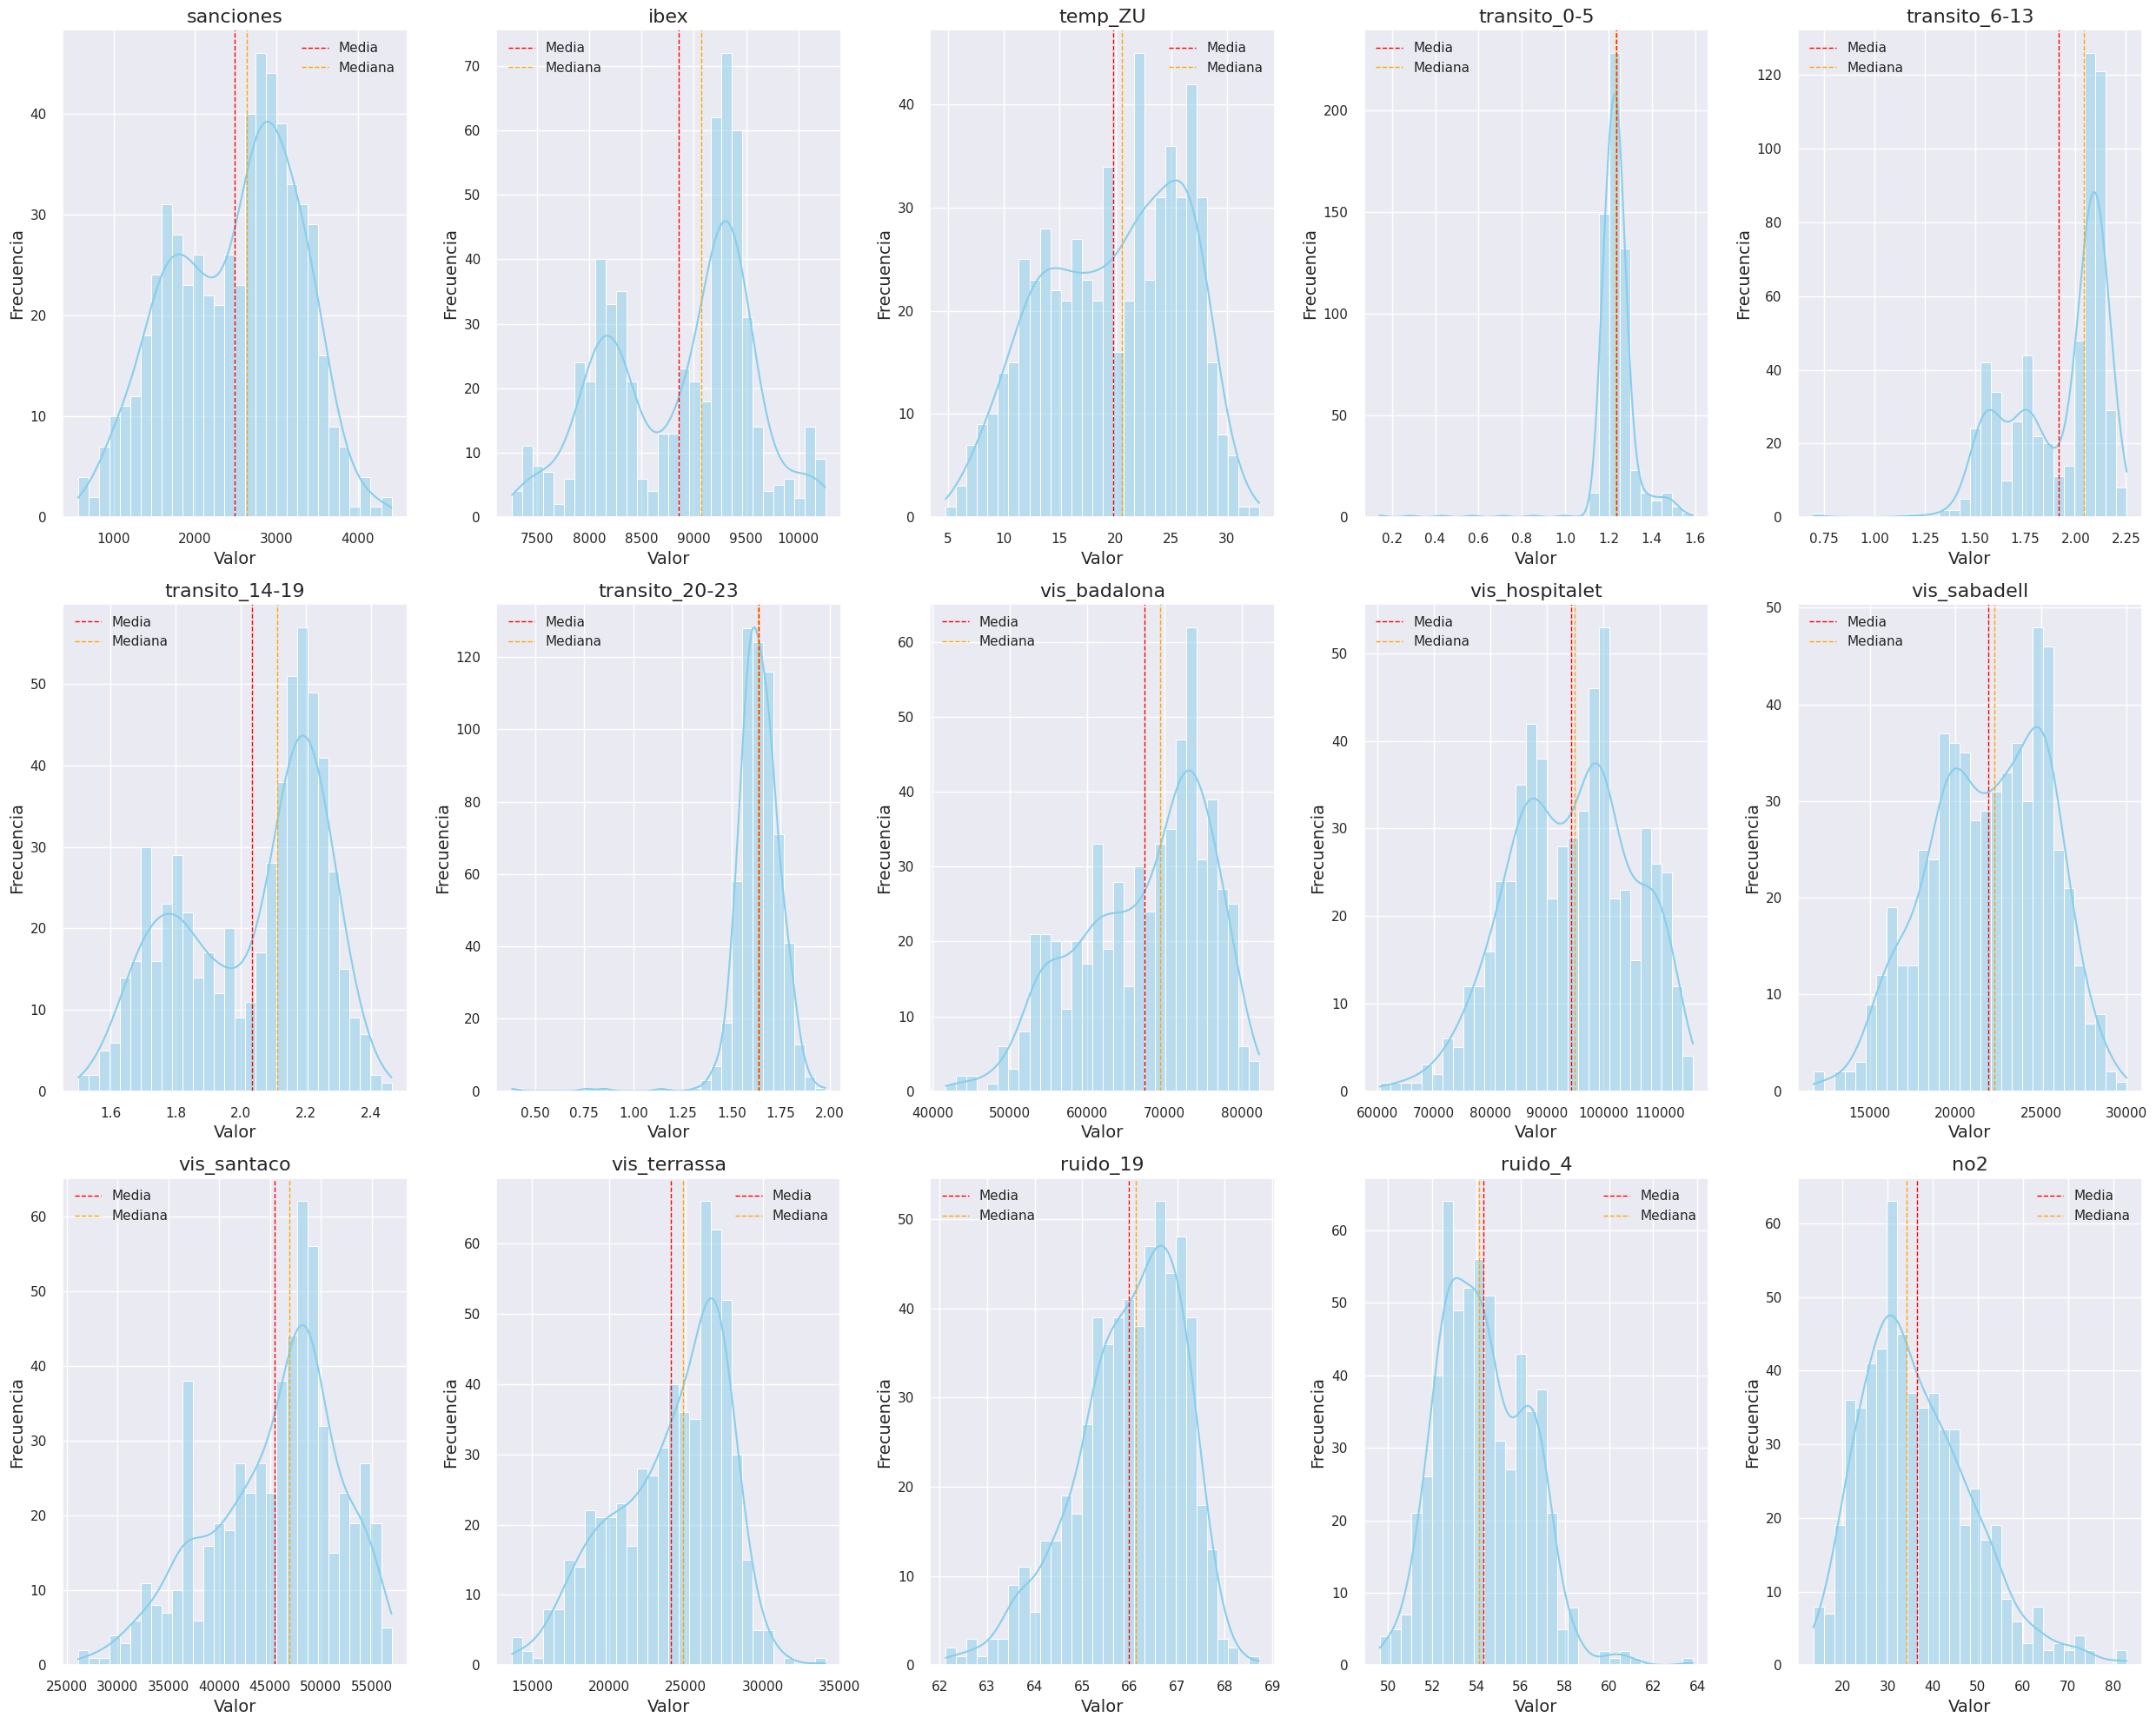

In [9]:
# raw_df.hist(figsize=(20,12));
fig, axes = plt.subplots(3, 5, figsize=(25, 20))

for i, c in enumerate(raw_df.columns):
    ax = axes.flatten()[i]
    sns.histplot(data=raw_df, x=c, ax=ax, bins=30, kde=True, color='skyblue')
    ax.set_title(c, fontsize=16)
    ax.set_xlabel('Valor', fontsize=14)
    ax.set_ylabel('Frecuencia', fontsize=14)

    mean = raw_df[c].mean()
    median = raw_df[c].median()
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Media')
    ax.axvline(median, color='orange', linestyle='dashed', linewidth=1, label='Mediana')
    ax.legend()

plt.tight_layout();
plt.show();

A excepción de el transito entre las 20 y 23 que seria la que sigue una distribucion mas parecida a una gaussiana, emos que en general las variables no siguen una distribucion gaussiana. Podemos ver en la mayoría de casos como se solapan dos o mas distribuciones gaussianas en la misma variable y en otras vemos como hay una de las dos colas de la campana mas pronunciada que la otra. Si quiseramos mejorar o ajustar nuestras distribuciones podriamos probar de aplicar logartimos a esas variables para obtener unos datos mas asemejados a distribuciones normales.



## Análisis de las relaciones entre variables


Para analizar correctamente las posibles realciones entre las variables de nestro data set, calculamos la matriz de covarianza (quedándonos con el triangulo inferior sin la diagonal).

De la matriz de covarianza observamos:
 - La variable tráfico de la mañana(de 6 a 13) y tráfico de la tarde(de 14 a 19) estan altamente correlacionados, lo que indica que probablemente no seria necesario diferenciar el tráfico de las horas diurnas en tramo de mañana y tarde.
 - Vemos que los visitantes de las distintas localidades estan altamente correlacionados entre si, lo que puede tener sentido ya que son localidades muy cercanas y los factores de visitar Bcn podrian afectar de forma parecida a dichas localidades.
 - Vemos también que el ruido por la noche esta inversamente correlacionado con casi todas las variables.
 - Observamos que variables como el ibex y no2 parecen no estar correlacionadas con casi ninguna otra variable (dado que no tienen un valor absoluto de variana elevado, podrian tratarse de variables espurias) lo que nos indica que son dos variables que aportan información que las demás variables no nos dan.
 - Finalmente si comparamos la correlación de la variable objetivo con el resto, nos podemos hacer una idea de que el numero de de visitantes que recibe de las distintas localidades es efectivamente un indicador importante,que podría concordar con la hipótesis lógica inicial de: a más personas, más sanciones.

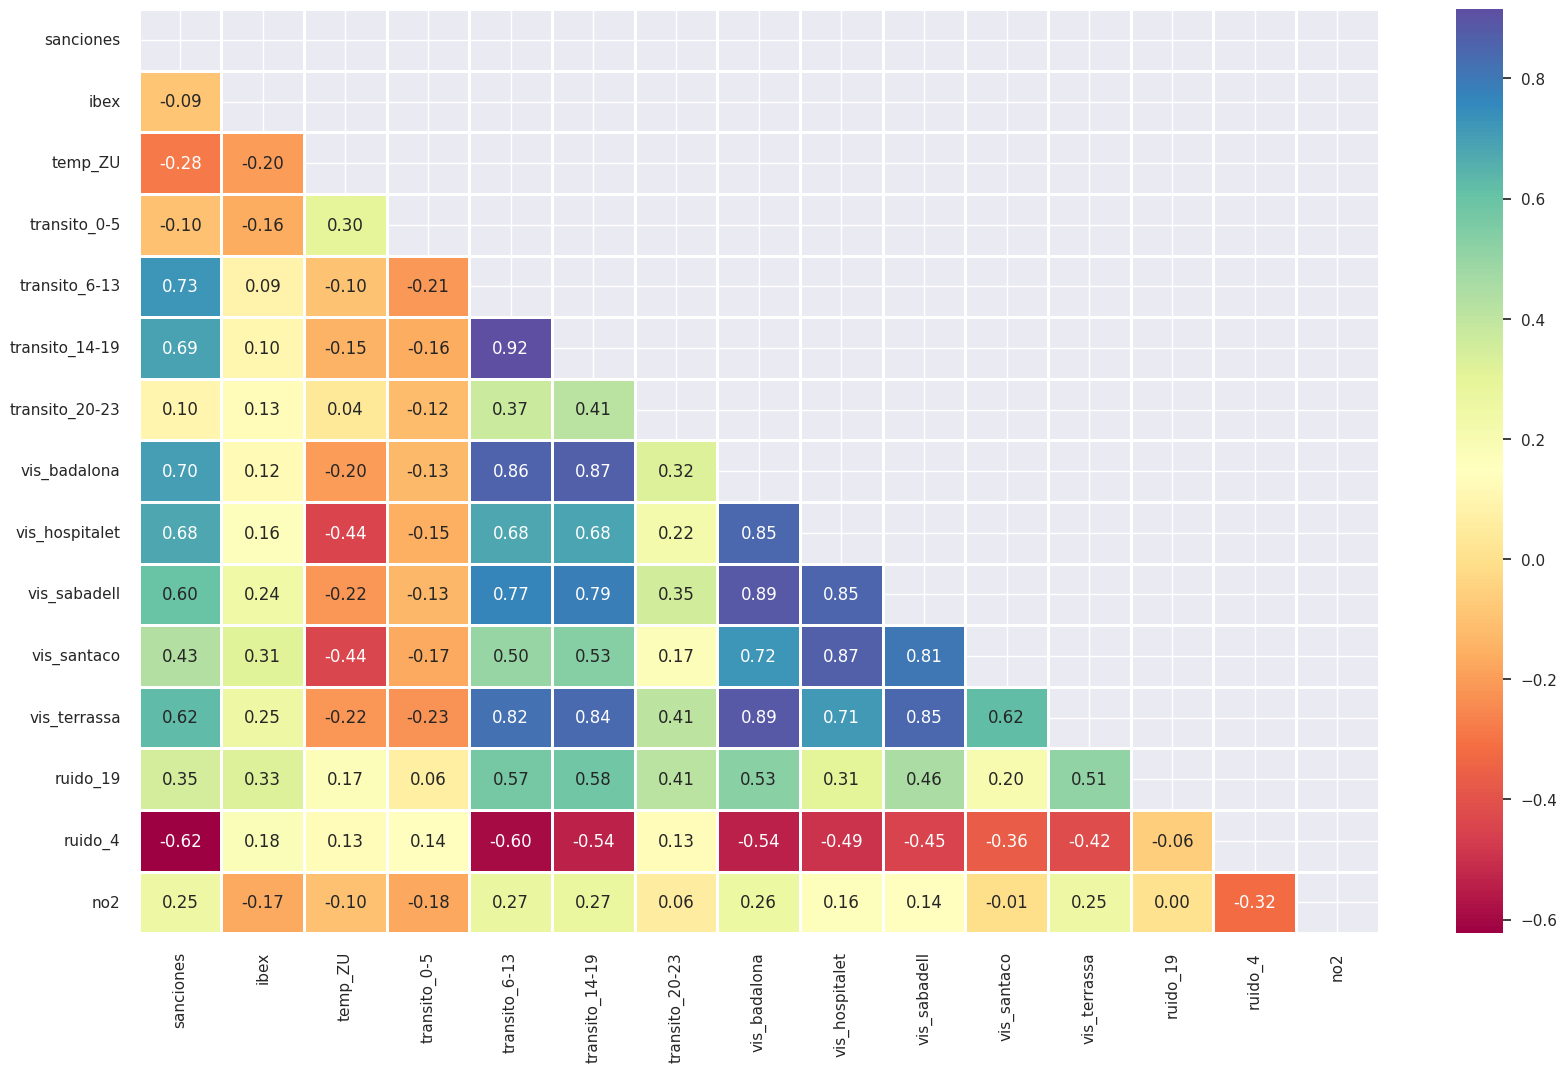

In [10]:
plt.figure(figsize=(20,12))
corr=raw_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap= 'Spectral', linewidths=1, annot=True, fmt = ".2f")
plt.show()

## Division del conjunto de datos y transformación

Dado que no se especifica ninguna tranformacion, standarización ni normalización, utilizaré un escalado MinMax el cual  ajusta cada valor de la variable para que esté dentro del rango deseado, calculando su posición relativa entre el valor mínimo y máximo de la misma variable.
<center>$\frac{X - X_{min}}{X_{max} - X_{min}}$</center>

In [11]:
from sklearn.preprocessing import MinMaxScaler

X = raw_df.loc[:,raw_df.columns != 'sanciones']
y = raw_df['sanciones']

def preprocessado(X, y,scaler=None):
    columns = [c for c in X.columns if c != 'sanciones']

    if scaler is None:
        scaler = MinMaxScaler()
        X[columns] = scaler.fit_transform(X[columns])
    else:
        X[columns] = scaler.transform(X[columns])

    X=X.dropna()
    y=y[X.index]
    print('New shape:{}'.format(X.shape))
    return X, y, scaler


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, y_train, scaler = preprocessado(X_train,y_train)
X_test, y_test, _ = preprocessado(X_test,y_test,scaler)

X_train.describe(include="all").T

New shape:(395, 14)
New shape:(195, 14)


,count,mean,std,min,25%,50%,75%,max
ibex,395.0,0.537,0.228,0.0,0.330,0.633,0.703,1.0
temp_ZU,395.0,0.537,0.217,0.0,0.345,0.582,0.719,1.0
transito_0-5,395.0,0.656,0.077,0.0,0.619,0.649,0.678,1.0
transito_6-13,395.0,0.778,0.153,0.0,0.657,0.859,0.902,1.0
transito_14-19,395.0,0.546,0.236,0.0,0.323,0.630,0.745,1.0
transito_20-23,395.0,0.766,0.100,0.0,0.716,0.764,0.824,1.0
vis_badalona,395.0,0.631,0.210,0.0,0.479,0.674,0.796,1.0
vis_hospitalet,395.0,0.616,0.200,0.0,0.466,0.631,0.756,1.0
vis_sabadell,395.0,0.580,0.201,0.0,0.444,0.602,0.747,1.0
vis_santaco,395.0,0.628,0.205,0.0,0.506,0.679,0.758,1.0


Vemos que los valores de las distintas variables se encuentran entre rangos de valores muy distintos, tenemos variables cuya mediana se encuentra entre 1 y 2 y por otra parte tenemos varibales que se encuentran entre valores del orden de 10^4, lo que nos indica que una transformacion de las variables es bastante necesaria.

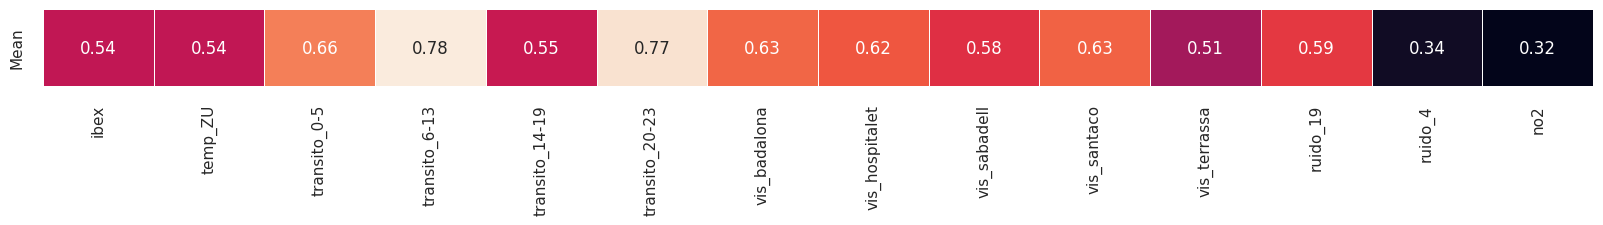

In [12]:
plt.figure(figsize = (20,1));
sns.heatmap(X_train.mean().to_frame().T.rename(index={0:'Mean'}),annot=True, linewidths=.5,cbar=False,xticklabels=True);

Mostramos la media de cada variable para comprobar que el escalado se ha realizado correctamente, es decir tenemos valores entre 0 y 1 que deberian estar aproximados al 0.5.

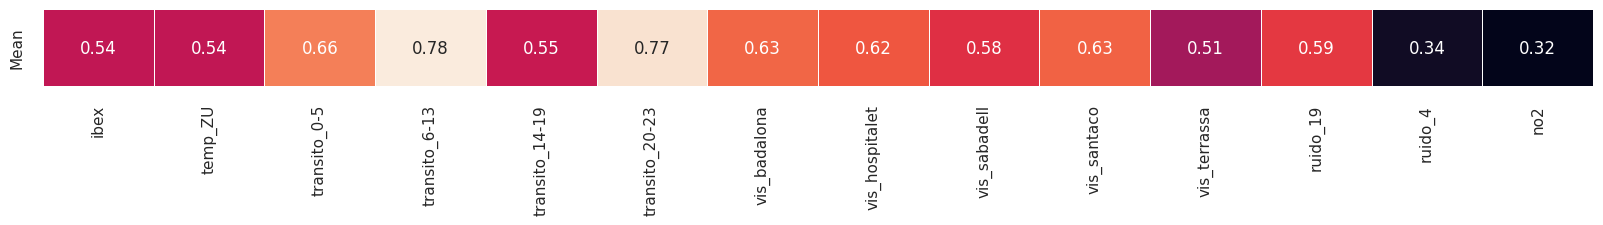

In [13]:
plt.figure(figsize = (20,1));
sns.heatmap(pd.DataFrame(X_train).mean().to_frame().T.rename(index={0:'Mean'}),annot=True, linewidths=.5, cbar=False, xticklabels=X.columns);

# Apartado B
Ajusta una regresión lineal, una regresión Ridge y una regresión LASSO a los datos ¿Te
parece suficientemente bueno el resultado? Representa los valores de la variable objetivo
para el conjunto de test contra las predicciones y observa los residuos y el qqplot. ¿Qué
modelo te parece mejor? ¿Hay alguna variable que haya descartado LASSO?


## Regresión lineal

Para medir los resultados tras aplicar una regresion lineal usaremos el metodo de validacion cruzada. Vemos que el coeficiente de determinacion o R2 que indica la proporción de la varianza de la variable dependiente que es explicada por el modelo explica el 70% de la variabilidad de los datos.

In [14]:
lr = LinearRegression().fit(X_train,y_train);
folds_r2 = cross_val_score(lr, X_train,y_train, cv=5, scoring='r2')
lr_r2 = np.mean(folds_r2)
print("R2: ", lr_r2)

R2:  0.7031650980774075


Pesos de los coeficientes y vaore del interceptor

In [15]:
weights = lr.coef_
intercept = lr.intercept_

print('Coeficientes: \n', weights)
print('Interceptor: \n', intercept)

Coeficientes: 
 [ -476.18997696  -714.82738777   688.05991797   918.69831123
   154.86996988  -733.64384419  -129.0310194   2567.70334005
  -219.54615455 -1650.44304443   842.82765207   842.5561088
 -1292.94676333  -215.42565023]
Interceptor: 
 1640.9515252726758


Usamos statsmodel para ver un análisis estadístico de los resultados

In [16]:
model = sm.OLS(y_train, sm.add_constant(X_train))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sanciones   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     80.64
Date:                Sun, 27 Oct 2024   Prob (F-statistic):          2.10e-104
Time:                        10:08:18   Log-Likelihood:                -2917.5
No. Observations:                 395   AIC:                             5865.
Df Residuals:                     380   BIC:                             5925.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1640.9515    340.258      4.823      0.000     971.928    2309.975
ibex            -476.1900    116.837     -4.076      0.000    -705.917    -246.463
temp_ZU         -714.8274    128.577     -5.560      0.000    -967.640    -462.015
transito_0-5     688.0599    299.761      2.295      0.022      98.661    1277.459
transito_6-13    918.6983    373.973      2.457      0.014     183.382    1654.014
transito_14-19   154.8700    254.350      0.609      0.543    -345.240     654.980
transito_20-23  -733.6438    262.519     -2.795      0.005   -1249.816    -217.471
vis_badalona    -129.0310    388.497     -0.332      0.740    -892.904     634.842
vis_hospitalet  2567.7033    321.439      7.988      0.000    1935.681    3199.725
vis_sabadell    -219.5462    289.526     -0.758      0.449    -788.820     349.727
vis_santaco    -1650.4430    267.746     -6.164      0.000   -2176.892   -1123.994
vis_terrassa     842.8277    306.466      2.750      0.006     240.246    1445.409
ruido_19         842.5561    199.662      4.220      0.000     449.975    1235.137
ruido_4        -1292.9468    223.248     -5.792      0.000   -1731.902    -853.991
no2             -215.4257    136.252     -1.581      0.115    -483.329      52.478
==============================================================================
Omnibus:                        7.053   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.029   Jarque-Bera (JB):               10.621
Skew:                           0.057   Prob(JB):                      0.00494
Kurtosis:                       3.795   Cond. No.                         62.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Vemos que el hisograma de los residuos no sigue una distribucion gaussiana lo precisa como deberia.

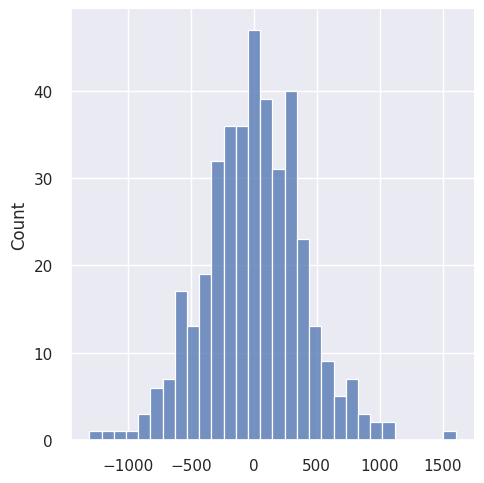

In [17]:
sns.displot(result.resid,bins=30);

Supondremos ahora que los residuos siguen una distribucion gaussiana y mostraremos su distribución y el qq-plot.

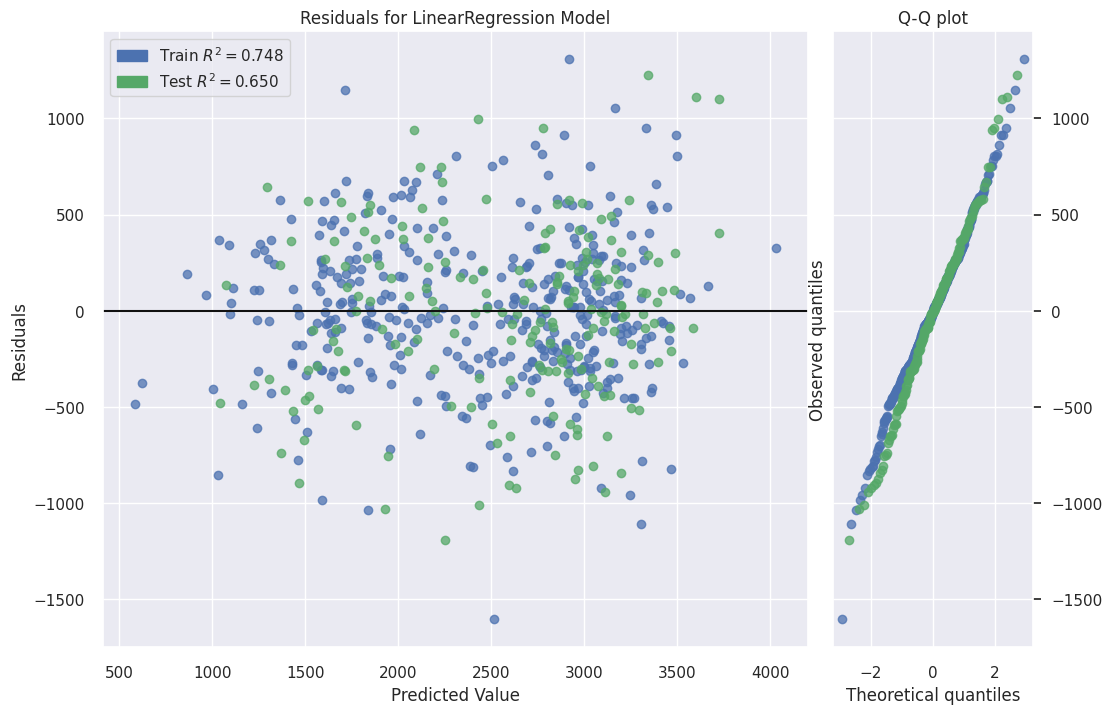

In [18]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8));
viz = residuals_plot(lr, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

Mostramos ahora los valores de la variable ojetivo para el conjunto de test contra las predicciones del modelo obtenido.

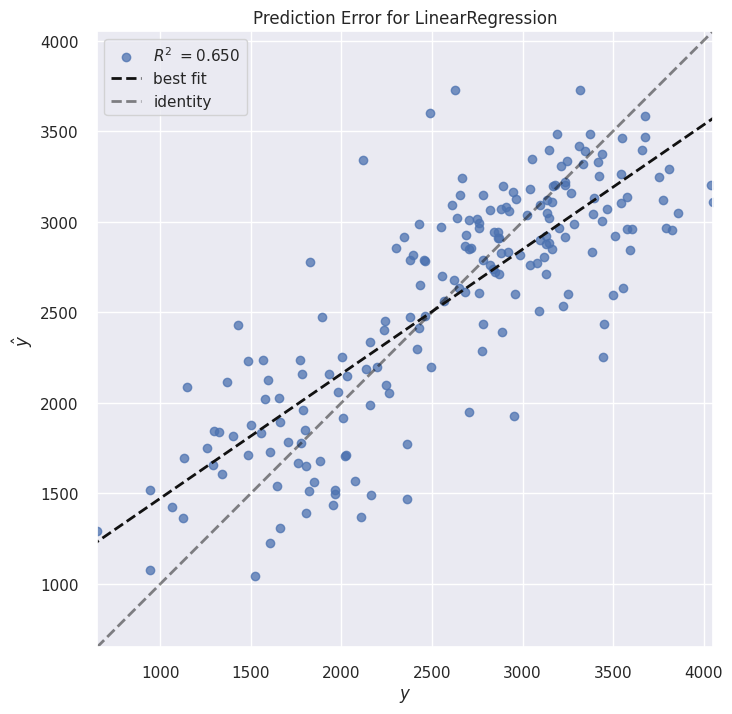

In [19]:
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(8,8))
visualizer = prediction_error(lr, X_test, y_test, is_fitted=True);

Vemos que al aplicar la regresión lineal al modelo, obtenemos un valor R2 algo bajo en el conjunto de entrenamiento, 0.748 y por otra parte, en el conjunto de test obtenemos un valor un 13% menor, 0.650. Esto nos indica que el modelo no puede ajustar del todo bien las sanciones con las variables que tenemos y podemos observar varianza en el modelo, o lo que es lo mismo, que hay un ligero sobreajuste en el modelo.

Por otra parte si observamos la distribución de los residuos, vemos que no siguen del todo una distribución gaussiana dado que vemos como los residuos tienen una ligera aglomeración en la zona de 3000 y otra un poco mas leve en a zona de los 1750.

Si analizamos el QQ-plot vemos que hay cierta discordancia con los cuantiles teoricos, vemos como en los dos primeros quantiles los dos conjuntos no se ajustan demasiado incluso podemos ver que los valores de entremaiento no siguen una linealidad muy alta. Por otra parte, observamos ciertas desviaciones en ambos extremos.

Y si observamos el gráfico del error en las predicciones, vemos que realmente el mejor ajuste esta muy lejos de la predicción ideal.

## Modelo Regularizado con Ridge

Procedemos ahora a aplicar la regularización L2 o regularizacion Ridge.



In [20]:
lambdas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]
ridge_cv = RidgeCV(alphas=lambdas,cv=5).fit(X_train,y_train)

print(f'Best lambda: {ridge_cv.alpha_} R2 score: {ridge_cv.best_score_:3.3f}')

Best lambda: 0.5 R2 score: 0.714


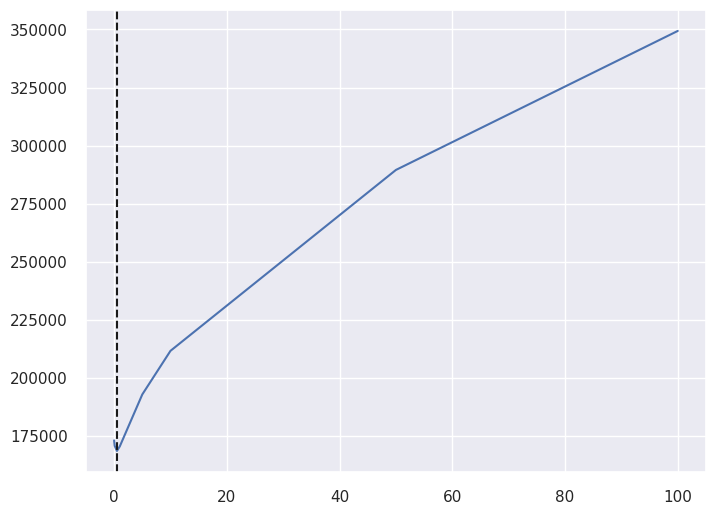

In [21]:
plt.figure(figsize=(8,6))
vis = AlphaSelection(RidgeCV(alphas=lambdas));
vis.fit(X_train, y_train);

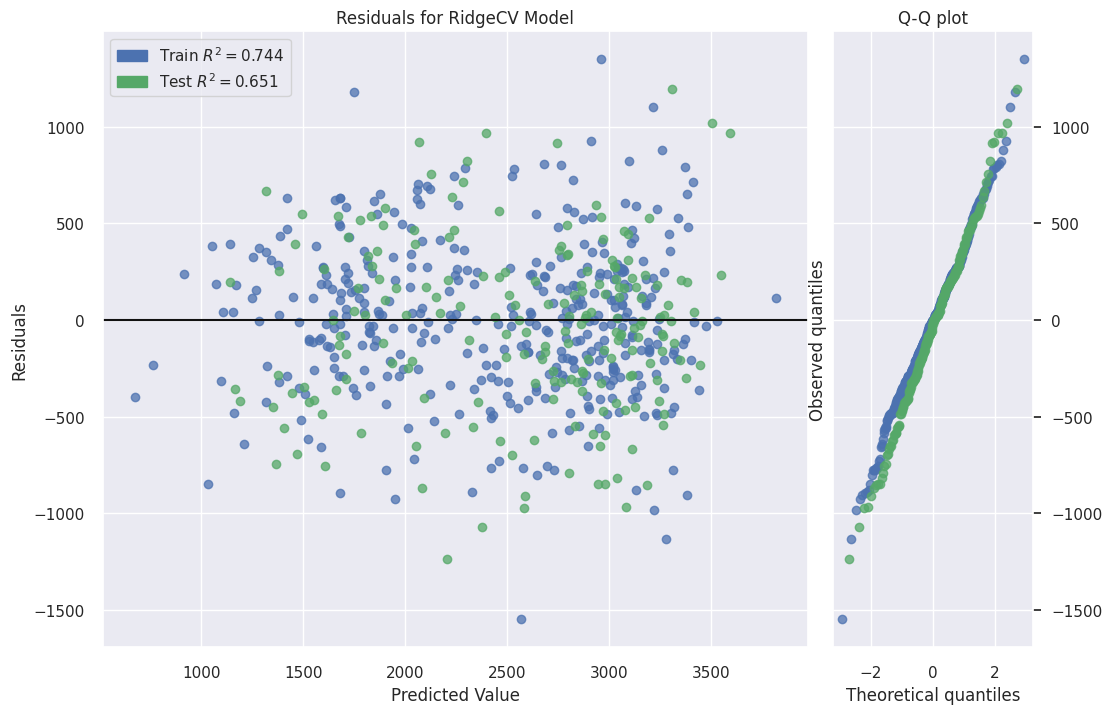

In [22]:
plt.figure(figsize=(12,8));
viz = residuals_plot(ridge_cv, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

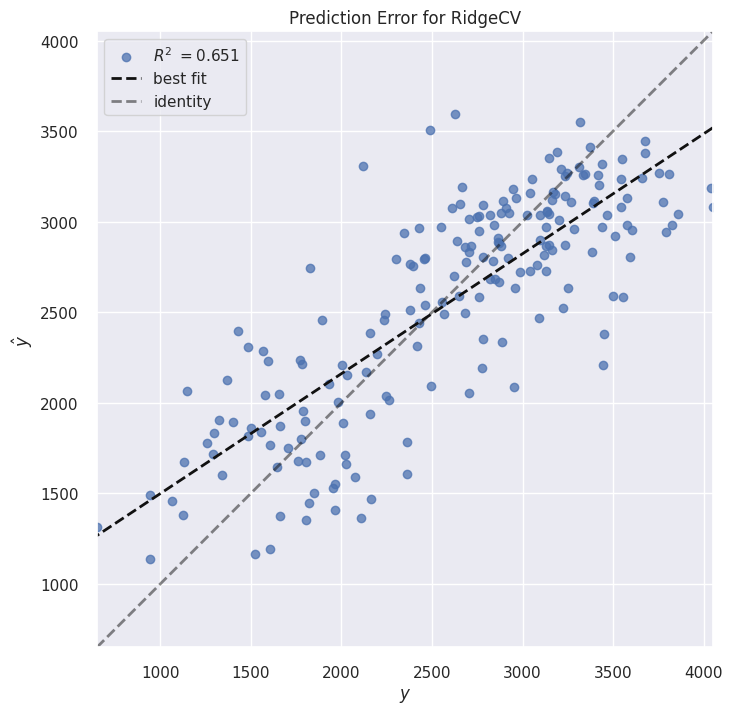

In [23]:
plt.figure(figsize=(8,8))
visualizer = prediction_error(ridge_cv, X_test, y_test, is_fitted=True);

## Modelo regularizado con LASSO

Procedemos ahora a aplicar una regularizacion L1 o regularizacion tipo LASSO

In [24]:
lasso_cv = LassoCV(alphas=lambdas,cv=5).fit(X_train,y_train)

lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train,y_train))

print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso_r2)

Best lambda: 1.0 R2 score: 0.7045706608961501


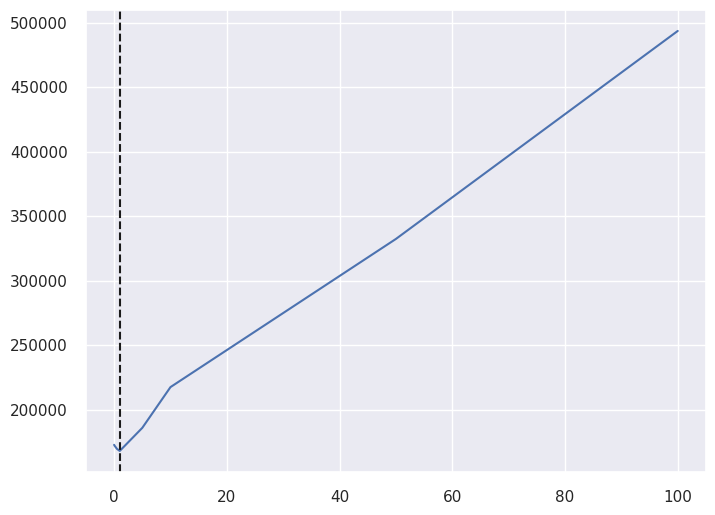

In [25]:
plt.figure(figsize=(8,6))
vis = AlphaSelection(LassoCV(alphas=lambdas));
vis.fit(X_train, y_train);

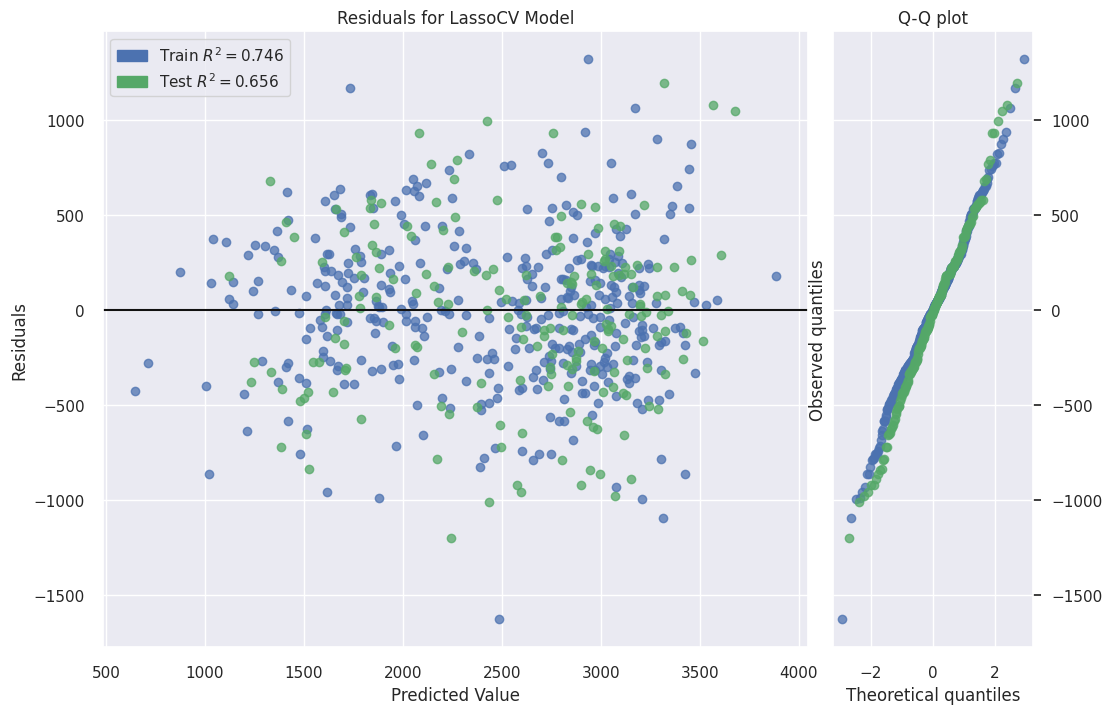

In [26]:
plt.figure(figsize=(12,8));
viz = residuals_plot(lasso_cv, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

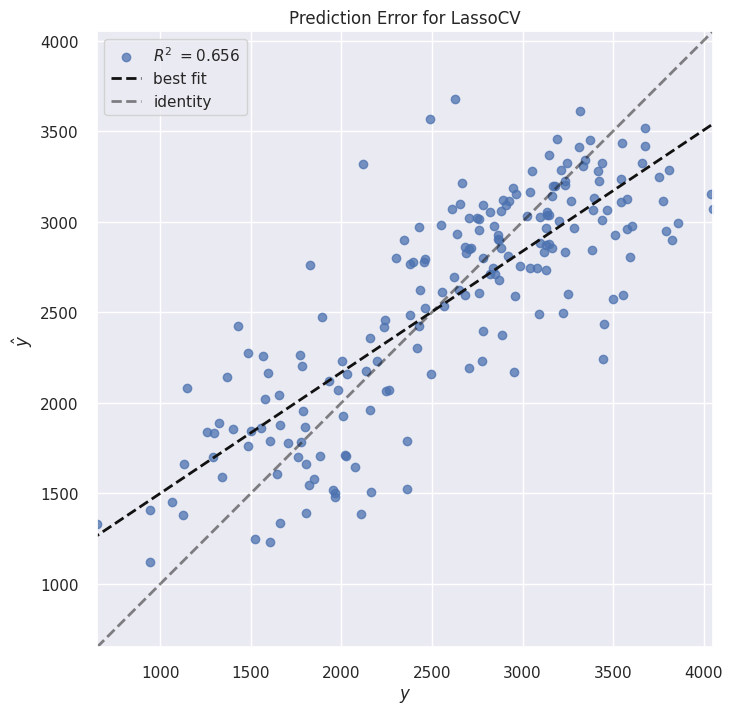

In [27]:
plt.figure(figsize=(8, 8))
visualizer = prediction_error(lasso_cv, X_test, y_test, is_fitted=True)

Podemos observar que los resultados al aplicar tanto una regresió lineal sin regularización como los resultados obtenidos al aplicar regularización no son lo suficientemente buenos como para poder ser aceptados (R2 > 0.8)

In [28]:
r2_results = pd.DataFrame({'lr':lr_r2, 'ridge_cv':ridge_cv.best_score_, 'lasso_cv':lasso_r2},index=['CV R2'])

r2_results.loc['Train R2', :] =[r2_score(y_train,lr.predict(X_train)),
                                r2_score(y_train,ridge_cv.predict(X_train)),
                                r2_score(y_train,lasso_cv.predict(X_train))]
r2_results.loc['lambda','lr']=0
r2_results.loc['lambda','ridge_cv']=ridge_cv.alpha_
r2_results.loc['lambda','lasso_cv']=lasso_cv.alpha_
print(r2_results)

             lr  ridge_cv  lasso_cv
CV R2     0.703     0.714     0.705
Train R2  0.748     0.744     0.746
lambda    0.000     0.500     1.000


Tras aplicar la regularización Lasso(L1) y la regularización Ridge(L2), vemos que tanto el modelo de Ridge como el modelo LASSO no nos dan unos resultados muy distintos a la regresión lineal.

Practicamente no podemos decir que un modelo sea mejor que el otro, mas allá de la regularización Ridge que si realizamos validacion cruzada vemos que obtenemos un valor de 0.71 cuando en los otros dos tenemos un valore menor que 0.7.

Para entender bien que estan haciendo los modelos, vamos a hacer un análisis de los pesos de cada modelo:

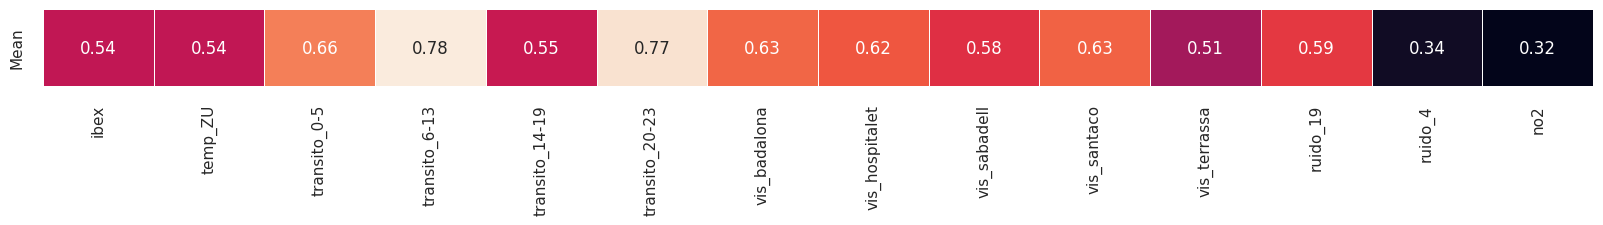

In [29]:
plt.figure(figsize = (20,1));
sns.heatmap(X_train.mean().to_frame().T.rename(index={0:'Mean'}),annot=True, linewidths=.5,cbar=False,xticklabels=True);

Vemos si LASSO descarta alguna variable


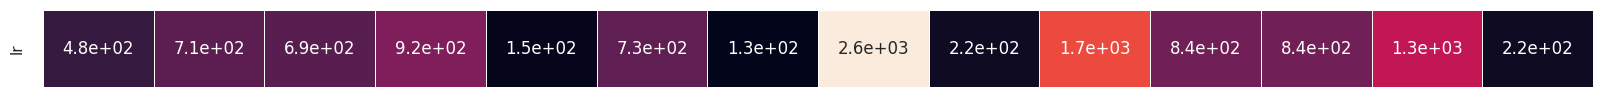

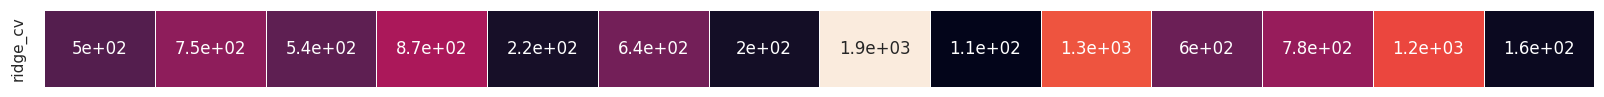

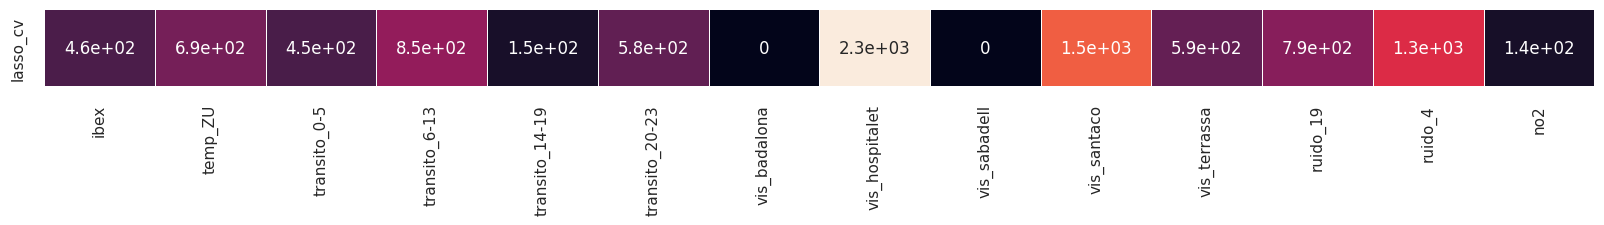

In [30]:
weights = pd.DataFrame({'lr':lr.coef_, 'ridge_cv':ridge_cv.coef_, 'lasso_cv':lasso_cv.coef_},index=X_train.columns)

fig,  ax = plt.subplots( figsize = (20,1));
sns.heatmap(weights.T.loc[['lr'],:].abs(),annot=True, linewidths=.5,ax=ax,cbar=False,xticklabels=False);

plt.figure(figsize = (20,1));
sns.heatmap(weights.T.loc[['ridge_cv'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=False);

plt.figure(figsize = (20,1));
sns.heatmap(weights.T.loc[['lasso_cv'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=True);

Si hechamos un vistazo al mapa de calor de la media de las variables y al mapa de calor de los pesos que se le asginan a cada variable en cada modelo, podemos ver que los tres modelos tratan de dar un peso mayor a aquellas medianas mas pequeñas y un peso menor a las medianas mas grandes.

Por otra parte toman prácticamente los mismos pesos para las variables lo que concorda con los resultados vistos en las gráficas.

La única diferencia significativa que vemos sería que el modelo LASSO descarta por completo las variables visitantes de badalona y visitantes de sabadell, las demás variables se comportan mas o menos igual.

# Apartado C

Otra manera de ver la relevancia de las variables en el modelo es comprobar la significatividad de los coeficientes de regresión. Ajustad una regresión lineal con todas las variables
usando el método OLS de la librería statsmodels (los pesos serán los mismos que los de
la regresión lineal) y analiza la significatividad que asigna el método al coeficiente de cada
variable. Explica lo que has visto. ¿Hay alguna posible razón para que algunas variables
no sean importantes? Elimina las variables que no son significativas y ajusta de nuevo el
mejor modelo. Comenta los resultados.

Para eliminar las variables que no son significativas nos debemos fijar en la P > |t| de cada variable, ya que si su valor supera a 0.05 la variables no será significativa.

In [31]:
model = sm.OLS(y_train, sm.add_constant(X_train))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sanciones   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     80.64
Date:                Sun, 27 Oct 2024   Prob (F-statistic):          2.10e-104
Time:                        10:08:31   Log-Likelihood:                -2917.5
No. Observations:                 395   AIC:                             5865.
Df Residuals:                     380   BIC:                             5925.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1640.9515    340.258      4.823      0.000     971.928    2309.975
ibex            -476.1900    116.837     -4.076      0.000    -705.917    -246.463
temp_ZU         -714.8274    128.577     -5.560      0.000    -967.640    -462.015
transito_0-5     688.0599    299.761      2.295      0.022      98.661    1277.459
transito_6-13    918.6983    373.973      2.457      0.014     183.382    1654.014
transito_14-19   154.8700    254.350      0.609      0.543    -345.240     654.980
transito_20-23  -733.6438    262.519     -2.795      0.005   -1249.816    -217.471
vis_badalona    -129.0310    388.497     -0.332      0.740    -892.904     634.842
vis_hospitalet  2567.7033    321.439      7.988      0.000    1935.681    3199.725
vis_sabadell    -219.5462    289.526     -0.758      0.449    -788.820     349.727
vis_santaco    -1650.4430    267.746     -6.164      0.000   -2176.892   -1123.994
vis_terrassa     842.8277    306.466      2.750      0.006     240.246    1445.409
ruido_19         842.5561    199.662      4.220      0.000     449.975    1235.137
ruido_4        -1292.9468    223.248     -5.792      0.000   -1731.902    -853.991
no2             -215.4257    136.252     -1.581      0.115    -483.329      52.478
==============================================================================
Omnibus:                        7.053   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.029   Jarque-Bera (JB):               10.621
Skew:                           0.057   Prob(JB):                      0.00494
Kurtosis:                       3.795   Cond. No.                         62.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Vemos que por lo tanto tenemos algunas variables como: "transito_14-19", "vis_badalona", "vis_sabadell" y "no2", que tienen una significatividad muy baja, en especial los visitantes de badalona con un valor de 0.740. Podemos probar ahora de ajustar una regresión lineal a los datos, eliminando esas variables del conjunto de datos.




 Podriamos tambien probar otros metodos como calcular el factor de Inflación de la Varianza (VIF) para detectar la multicolinealidad entre las características de un conjunto de datos, aunque en este caso solo utilizaremos el valor de P > |t| para descartar variables, ya que es el que vimos en las sesiones de laboratorio.

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
print(vif)

    VIF Factor        features
0       11.511            ibex
1       13.741         temp_ZU
2       59.608    transito_0-5
3      139.499   transito_6-13
4       52.146  transito_14-19
5       92.409  transito_20-23
6      164.288    vis_badalona
7      108.091  vis_hospitalet
8       74.832    vis_sabadell
9       72.028     vis_santaco
10      67.551    vis_terrassa
11      36.575        ruido_19
12      16.304         ruido_4
13       5.820             no2


### Eliminamos variables no significativas

In [33]:
X_train_new = X_train.drop(['transito_14-19', 'vis_badalona', 'vis_sabadell', 'no2'], axis=1)
X_test_new = X_test.drop(['transito_14-19', 'vis_badalona', 'vis_sabadell', 'no2'], axis=1)
y_test_new = y_test
y_train_new = y_train

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
vif["features"] = X_train_new.columns
print(vif)

   VIF Factor        features
0      10.171            ibex
1      12.129         temp_ZU
2      56.406    transito_0-5
3     111.139   transito_6-13
4      85.218  transito_20-23
5      88.880  vis_hospitalet
6      58.875     vis_santaco
7      34.021    vis_terrassa
8      28.035        ruido_19
9      14.693         ruido_4


## Ajustamos de nuevo a los modelos

In [34]:
lr = LinearRegression().fit(X_train_new,y_train_new);
folds_r2 = cross_val_score(lr, X_train_new,y_train_new, cv=5, scoring='r2')
lr_r2 = np.mean(folds_r2)
print("R2: ", lr_r2)

R2:  0.7179575718536182


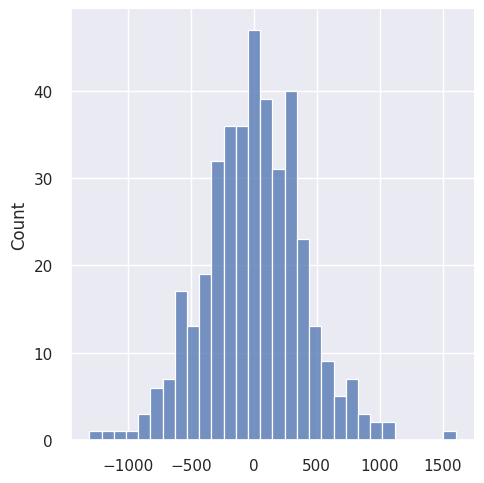

In [35]:
sns.displot(result.resid,bins=30);

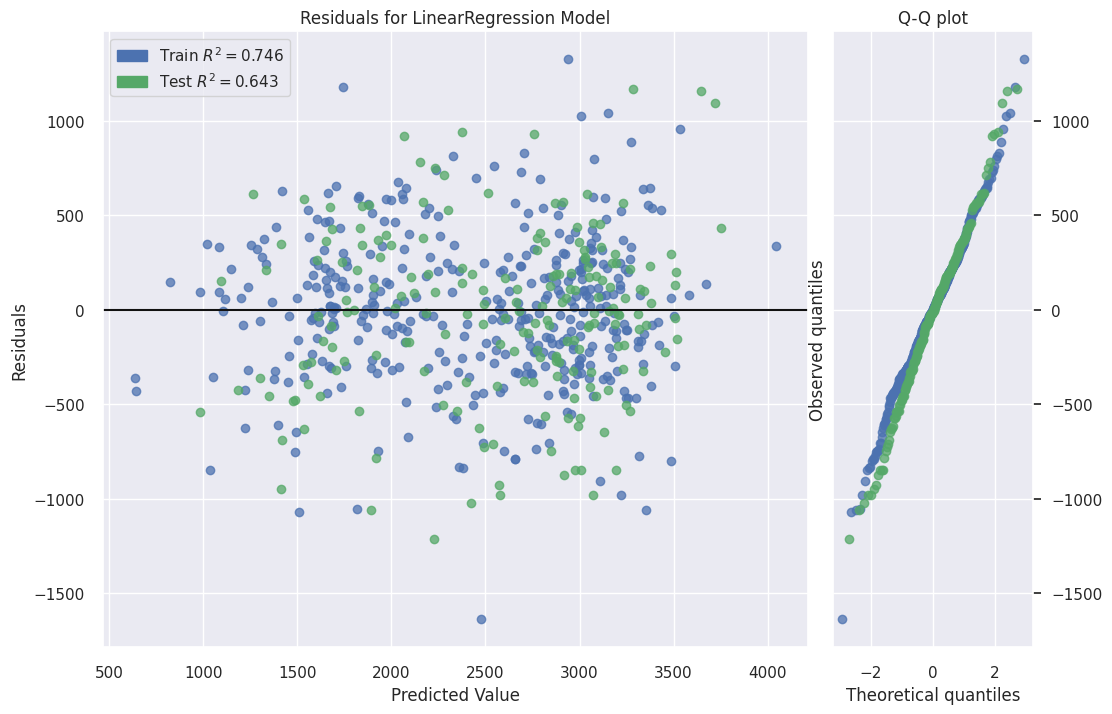

In [36]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8));
viz = residuals_plot(lr, X_train_new, y_train_new, X_test_new, y_test_new, is_fitted=True, qqplot=True, hist=False);

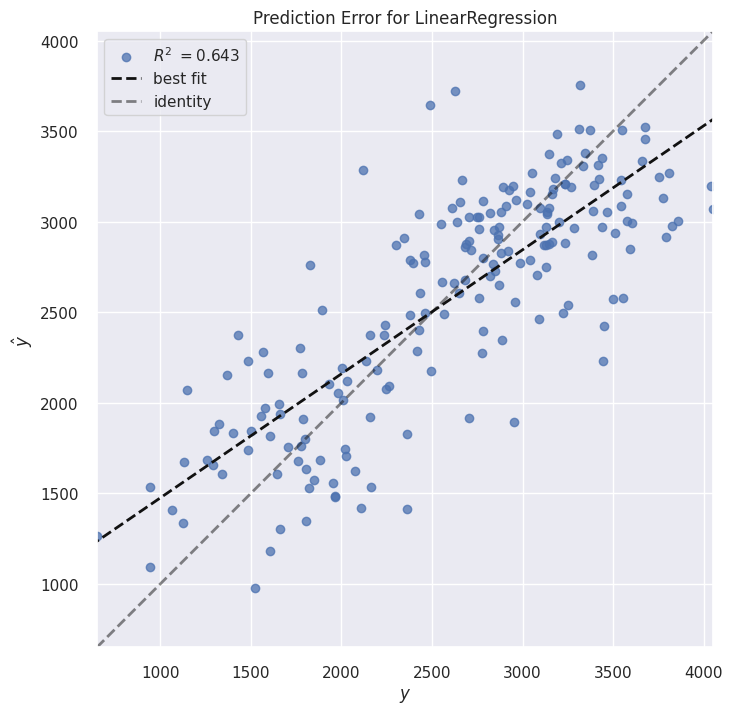

In [37]:
plt.figure(figsize=(8,8))
visualizer = prediction_error(lr, X_test_new, y_test_new, is_fitted=True);

In [38]:
lambdas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]
ridge_cv = RidgeCV(alphas=lambdas,cv=5).fit(X_train_new,y_train_new)

print(f'Best lambda: {ridge_cv.alpha_} R2 score: {ridge_cv.best_score_:3.3f}')

Best lambda: 0.1 R2 score: 0.719


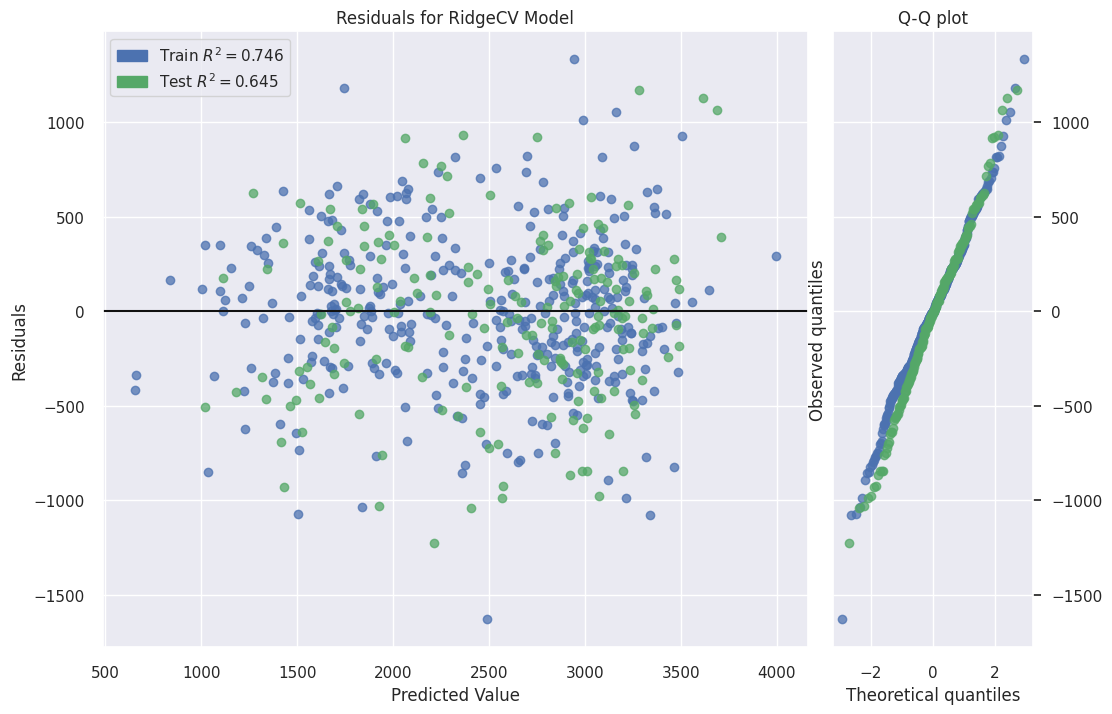

In [39]:
plt.figure(figsize=(12,8));
viz = residuals_plot(ridge_cv, X_train_new, y_train_new, X_test_new, y_test_new, is_fitted=True, qqplot=True, hist=False);

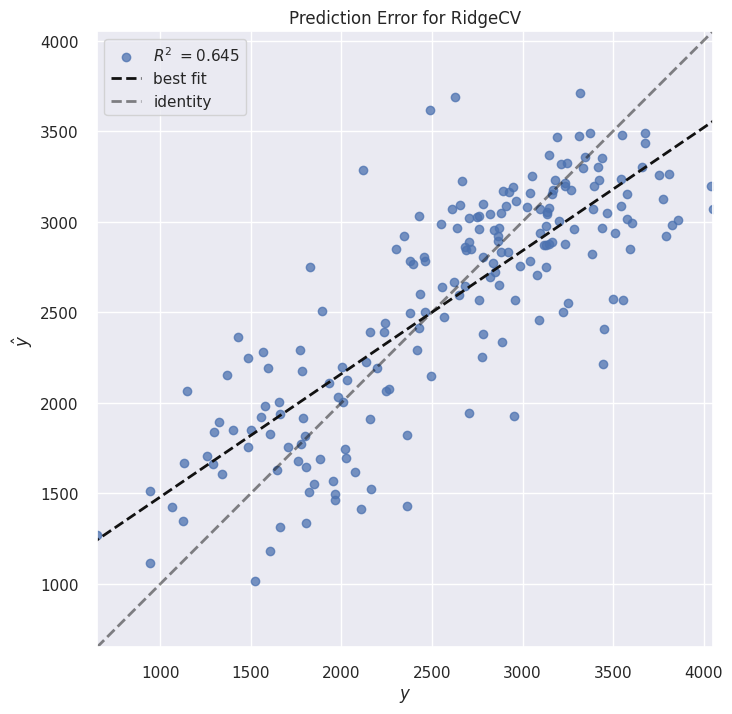

In [40]:
plt.figure(figsize=(8, 8))
visualizer = prediction_error(ridge_cv, X_test_new, y_test_new, is_fitted=True)

In [41]:
lasso_cv = LassoCV(alphas=lambdas,cv=5).fit(X_train_new,y_train_new)

lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train_new,y_train_new))

print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso_r2)

Best lambda: 0.1 R2 score: 0.7180437876331114


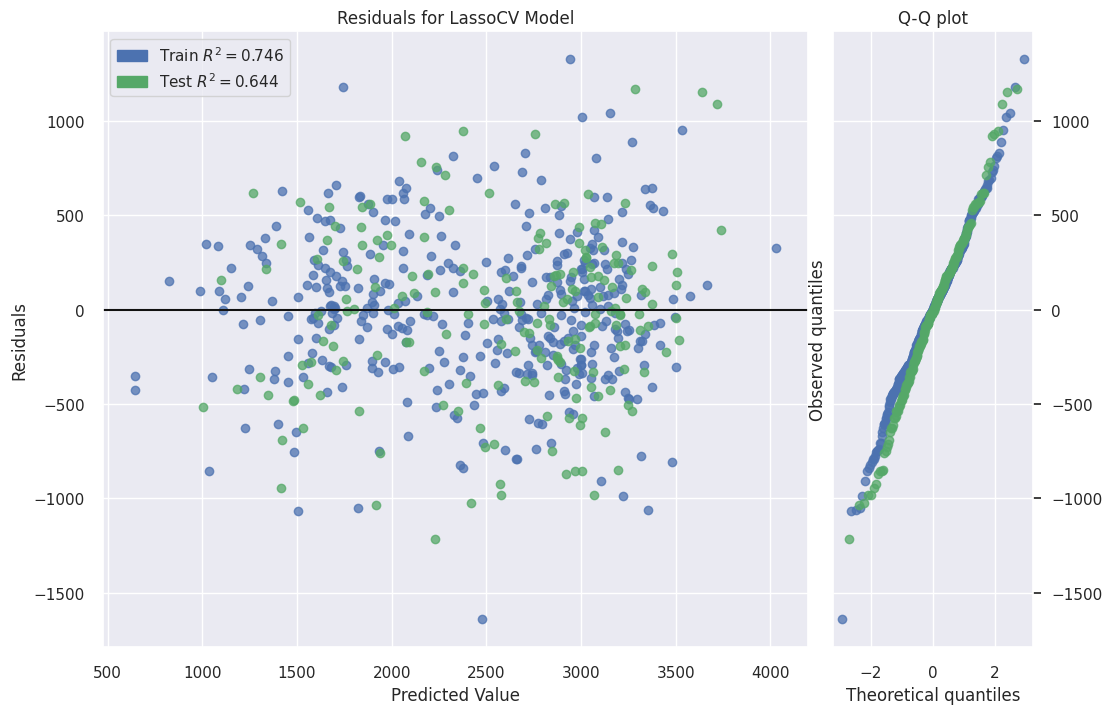

In [42]:
plt.figure(figsize=(12,8));
viz = residuals_plot(lasso_cv, X_train_new, y_train_new, X_test_new, y_test_new, is_fitted=True, qqplot=True, hist=False);

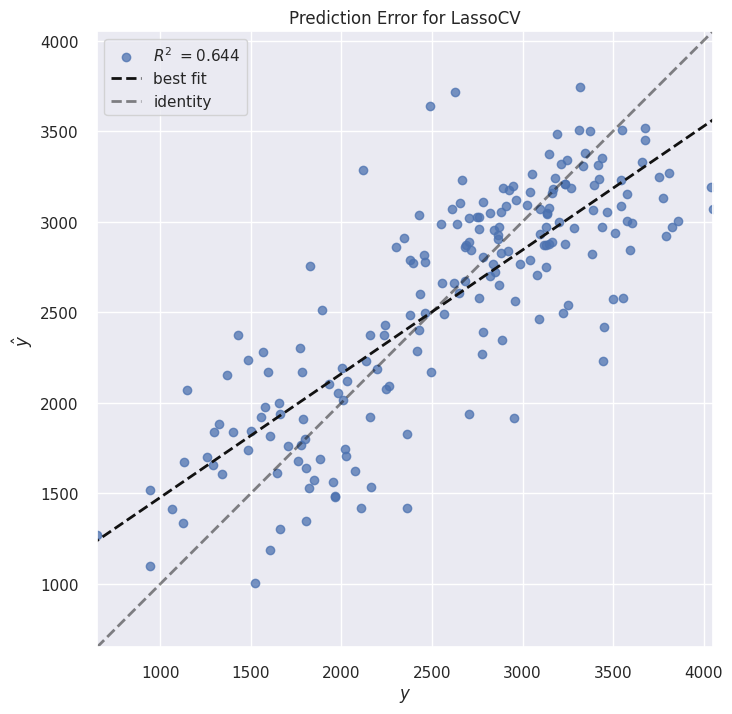

In [43]:
plt.figure(figsize=(8, 8))
visualizer = prediction_error(lasso_cv, X_test_new, y_test_new, is_fitted=True)

In [44]:
r2_results = pd.DataFrame({'lr':lr_r2, 'ridge_cv':ridge_cv.best_score_, 'lasso_cv':lasso_r2},index=['CV R2'])

r2_results.loc['Train R2', :] = [r2_score(y_train_new,lr.predict(X_train_new)),
                                r2_score(y_train_new,ridge_cv.predict(X_train_new)),
                                r2_score(y_train_new,lasso_cv.predict(X_train_new))]

r2_results.loc['lambda','lr']=0
r2_results.loc['lambda','ridge_cv']=ridge_cv.alpha_
r2_results.loc['lambda','lasso_cv']=lasso_cv.alpha_
r2_results

,lr,ridge_cv,lasso_cv
CV R2,0.718,0.719,0.718
Train R2,0.746,0.746,0.746
lambda,0.000,0.100,0.100


Tras ajustar los datos con las variables significativas, vemos que el hecho de eliminar las variables menos significativas del conjunto de datos sigue sin aportarnos mejores resultados.

Vemos que el valor de el R2 en la CV aumenta un poco y a su vez disminuye un poco el valor de R2 en los datos de entrenamiento.

Por lo que hace a los graficos de los residuos, del error predecido y del qq-plot no observamos practicamente ninguna variación.

# Apartado D
Siempre es posible que haya interacciones entre las variables que expliquen cosas que
no obtengamos con las variables individuales. Usa la función PolynomialFeatures de
scikit-learn para añadir características al conjunto de datos que correspondan a polinomios
de grado 2. Ajusta de nuevo una regresión lineal, Ridge y LASSO para estas variables y
evalúa la calidad de los modelos. Representa las predicciones respecto a los valores reales
y comenta lo que observes. Compara las predicciones con las del mejor modelo con las
variables originales.

### Añadir posibles características escondidas

Añadimos características al conjunto de datos mediante polinomios de grado 2 con la funcion de PolynomialFeatures.

In [45]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

Ajustamos los nuevos datos a los tres modelos

In [46]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)
y_pred_lin = lin_reg.predict(X_test_poly)

ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_poly, y_train)
y_pred_ridge = ridge_reg.predict(X_test_poly)

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_poly, y_train)
y_pred_lasso = lasso_reg.predict(X_test_poly)


Vemos la evaluacion de los modelos

In [47]:
def evaluate_model(y_test, y_pred, model_name):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, R-squared: {r2:.4f}")

evaluate_model(y_test, y_pred_lin, "Linear Regression")
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
evaluate_model(y_test, y_pred_lasso, "Lasso Regression")


Linear Regression - MSE: 663229.2456, R-squared: -0.1962
Ridge Regression - MSE: 158283.6626, R-squared: 0.7145
Lasso Regression - MSE: 158544.5869, R-squared: 0.7141


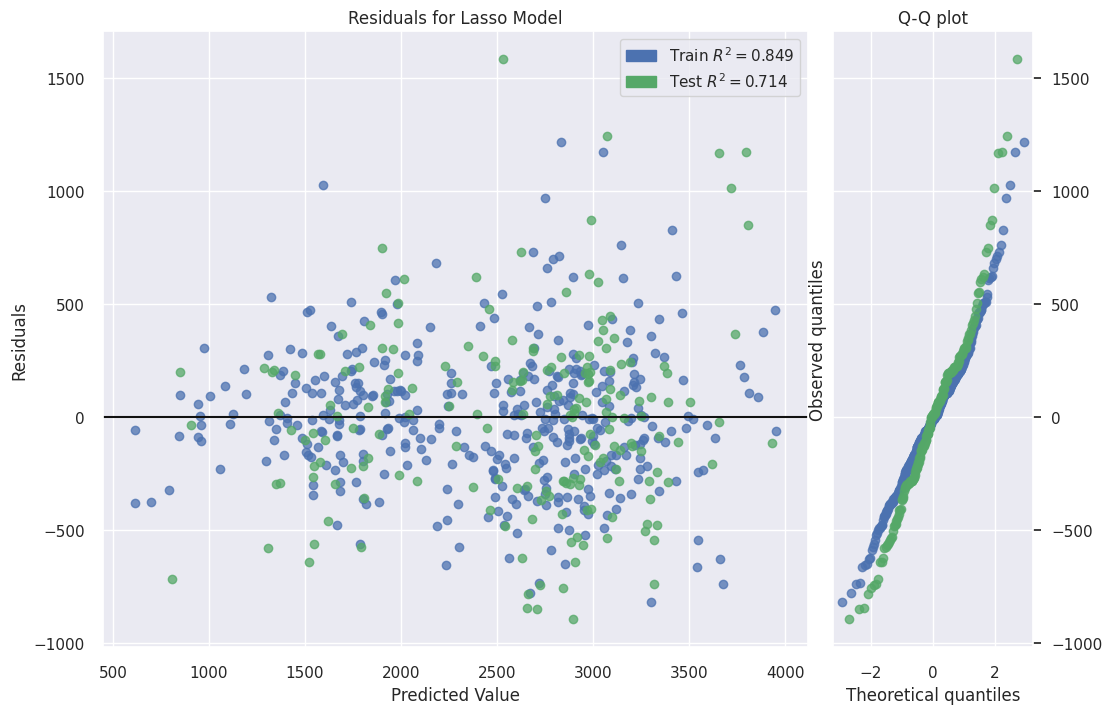

In [48]:
plt.figure(figsize=(12,8));
viz = residuals_plot(lasso_reg, X_train_poly, y_train, X_test_poly, y_test, is_fitted=True, qqplot=True, hist=False);

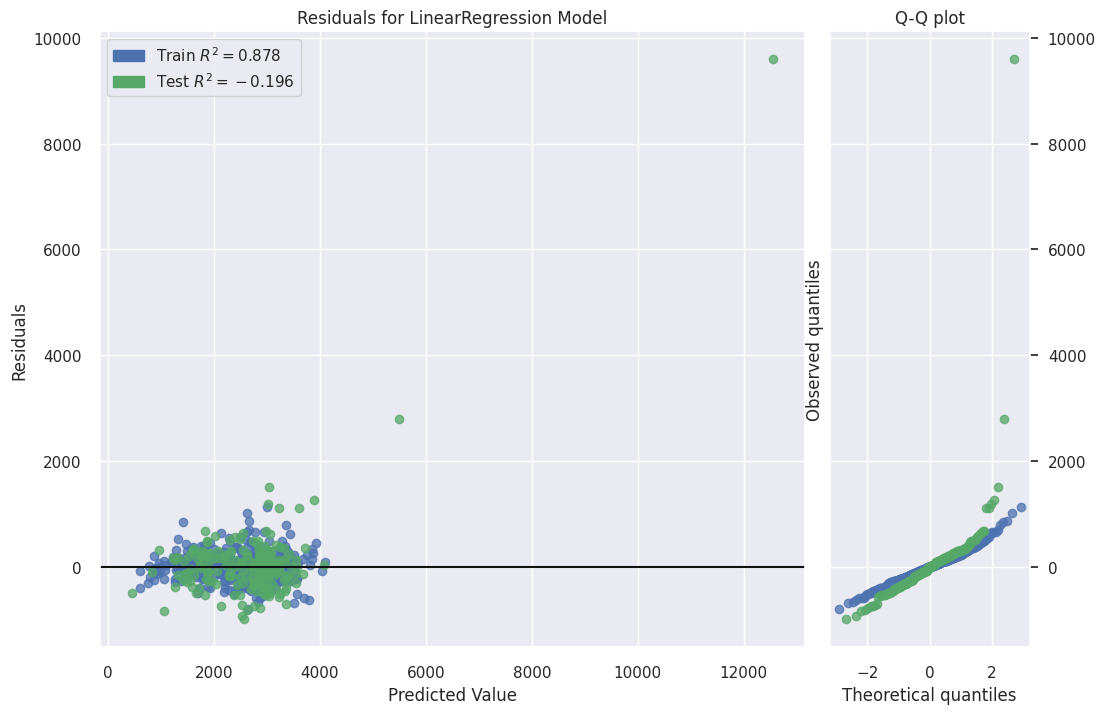

In [49]:
plt.figure(figsize=(12,8));
viz = residuals_plot(lin_reg, X_train_poly, y_train, X_test_poly, y_test, is_fitted=True, qqplot=True, hist=False);

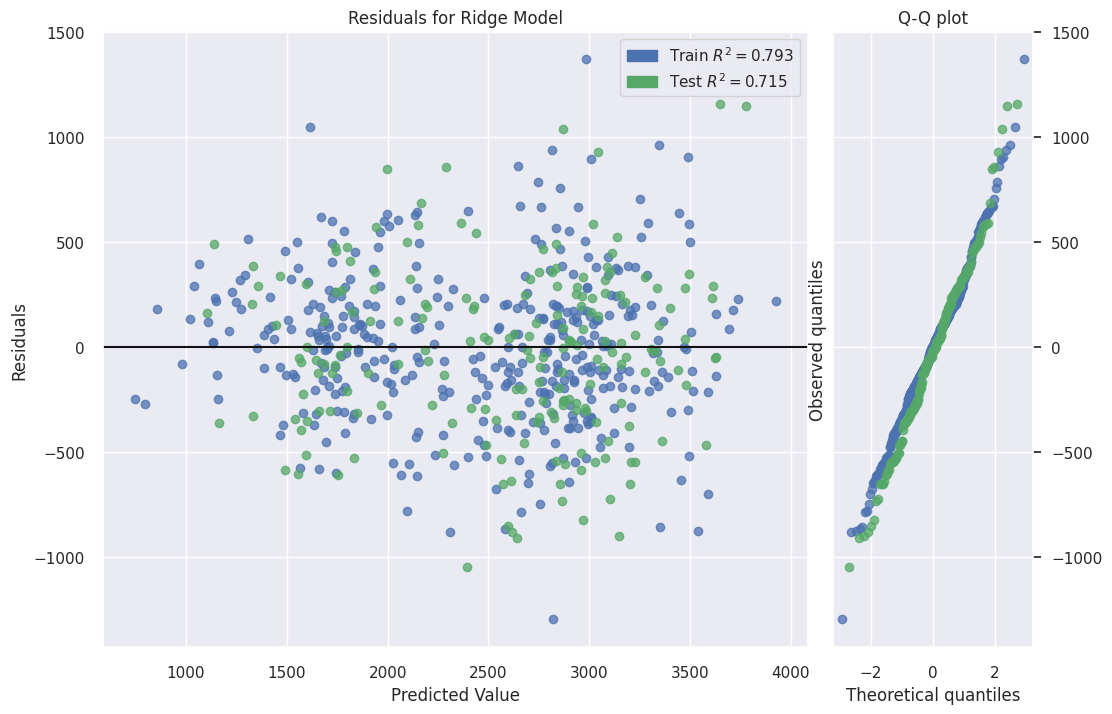

In [50]:
plt.figure(figsize=(12,8));
viz = residuals_plot(ridge_reg, X_train_poly, y_train, X_test_poly, y_test, is_fitted=True, qqplot=True, hist=False);

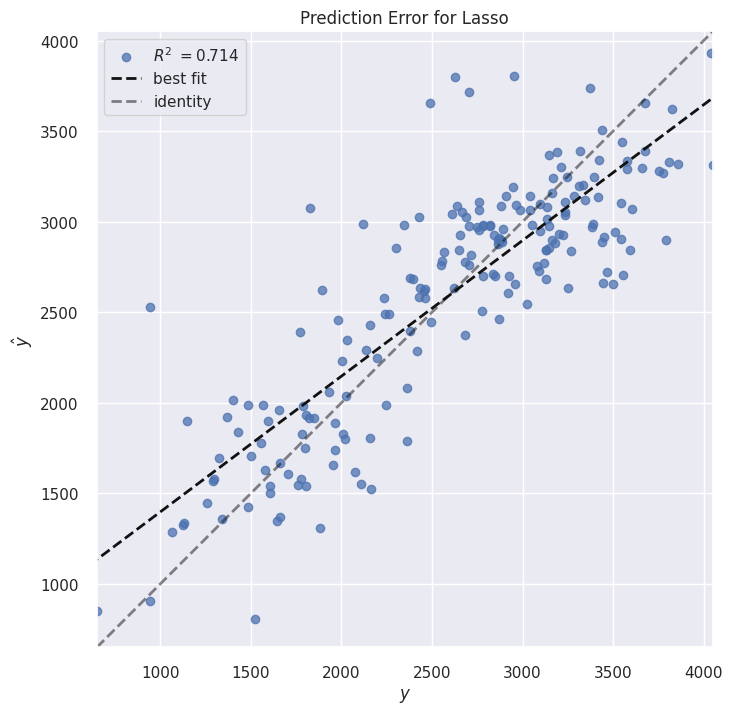

In [51]:
plt.figure(figsize=(8, 8))
visualizer = prediction_error(lasso_reg, X_test_poly, y_test, is_fitted=True)

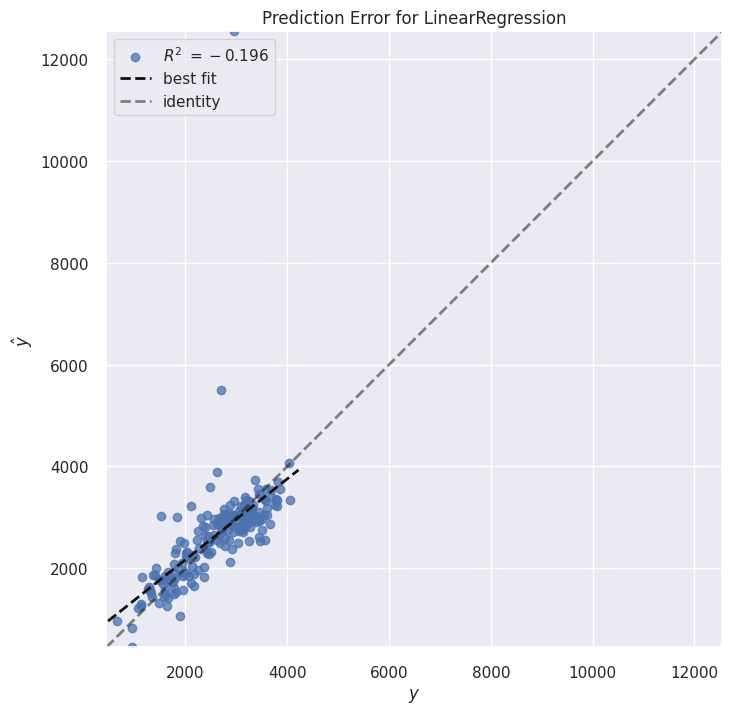

In [52]:
plt.figure(figsize=(8, 8))
visualizer = prediction_error(lin_reg, X_test_poly, y_test, is_fitted=True)

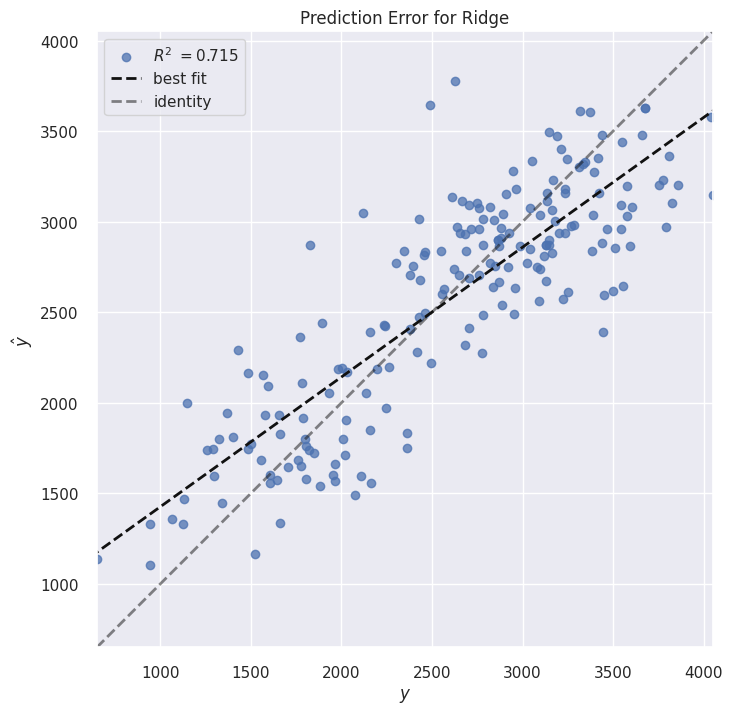

In [53]:
plt.figure(figsize=(8, 8))
visualizer = prediction_error(ridge_reg, X_test_poly, y_test, is_fitted=True)

### Regresion lineal con polinomios de grado 2.

Vemos que debido a que ahora las variables son combinaciones de las variables originales formando polinomios de grado 2, cuando hacemos la regresion lineal hay dos ocurrencias en el conjunto de test que tienen valores muy distintos a los valores del conjunto de entrenamiento, estos provocan que el ajuste con la regression lineal sea deastroso. En el caso del ajuste con LASSO y Ridge, mediante la regularizacion somos capaces de reducir esos casos y obtenemos mejores resultados.

### Comparacion de las predicciones con las del mejor modelo con las variables originales.

(Dado que los tres modelos con las variables originales obtenian resultados muy parecidos haremos una comparacion con ellos sin especificar uno en concreto)

Vemos que por norma general obtenemos valores de R2 mejores al utilizar los polinomios de grado 2 como variables, vemos un incremento considerable en el valor de R2 para el conjunto de datos de entrenamiento, pero a su vez, no observamos ningun augmento drástico en el valor de R2 de los valores de test.

A pesar de que el histograma de los residuos parezca gausiano y haya reducido la dispersidad de los residuos, hay cierta discordancia con los cuantiles teoricos, pese a que conservan una forma bastante lineal podemos ver que los residuos se comportan de manera diferente dependiendo del valor que se predice. Y sobretodo vemos que sigue habiendo un gran desbalance en los extremos.

Como conclusiones finales podriamos decir que:
- si dispusiesemos de un conjunto de datos mayor seguramente podriamos tratar de mejorar los ajustes para los conjuntos de entrenamiento
- si dispusiesemos de variables realmente significativas para el problema que estamos tratando, como número de vehiculos en circulación para cada dia o el numero de servicios de deteccion de multas(radares, camaras moviles...) disponibles para cada dia, el número de agentes de guardia urbana operativos para cada día, tal vez podriamos reducir entonces el supuesto sesgo que obtendriamos al añadir muchos datos y mejorar tanto en el conjunto de entrenamiento como en el de test o incluso añadir variables que nos indiquen la situación meteorológica del día.
- puede que no todos los ejemplos provengan del mismo proceso, basicamente intervienen otros factores que son relevantes para algunas muestras que hacen que se comporten diferente por ejemplo eventos que puedan acotecer en la ciudad, calles cortadas...
- todo indica a que las muestras no sean realmente independientes, como hemos visto en los análisis, por lo que debemos si quisesemos obtener mejores resultados, no nos basta con aplicar modelos lineales con regularización, deberiamos tambien mejorar la calidad y la cantidad de nuestros datos.